# PyTorch Neural Network training (overfitting on a very small dataset)
In this notebook, we will show how to train a shallow ResNet network on <b>keypoints estimation</b> task with synthetic data. To make the notebook fast to run, we will use a small dataset of 100 images and overfit the network to this dataset. <br>
Therefore, the goal of this notebook is to guide you through building a synthetic data training pipeline, and not to get state-of-the-art results.<br>
The second step will be to add a small amount of real data in the dataset and perform fine-tuning.

## Imports

In [ ]:
import os
from os.path import join
import numpy as np
import torch
from torch import nn
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torchvision.transforms import ToTensor
from torchvision import models
import matplotlib.pyplot as plt
import cv2
from imgaug import augmenters as iaa
from IPython import display
import pandas as pd
import csv

import datagen
from dghelpers import imshow, plot_grid

## Constants definition
The training and test data is located in the main directory. We save a checkpoint of the network locally. The dataset is splitted into <b>90 training images</b> and <b>10 test images.</b>

In [2]:
# The directory containing real and synthetic datasets
DATASETS_PATH = '../Neural Network Data'
SYNTH_DATASET_PATH= join(DATASETS_PATH, 'Synthetic')
# The file that contains the neural network weights
MODEL_PATH = "model.pth"
# The size of the input image
IMG_SIZE = 128

# This should ideally should be a power of 2 for compute efficiency
BATCH_SIZE = 45 

# Number of synthetic training samples
SYNTH_TRAINING_SAMPLES = 90

# Number of real training samples
REAL_TRAINING_SAMPLES = 50

# Ratio between the amount of synthetic and real samples during fine-tuning
# We give a different weight to both datasets to match this ratio
SYNTH_REAL_RATIO = 1

# Number of training and fine-tuning iterations
TRAINING_EPOCHS = 100
FINE_TUNING_EPOCHS = 100

NUMBER_OF_KEYPOINTS = 68

## Network definition
We use a <b>ResNet-18</b> network and replace the last fully connected layer with a dense layer that regresses the keypoints locations

In [3]:
# Model functions
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.cnn_stack = models.resnet18(pretrained=True)
        self.cnn_stack.fc = nn.Linear(self.cnn_stack.fc.in_features, NUMBER_OF_KEYPOINTS * 2)

    def forward(self, x):
        return self.cnn_stack(x)

## Datagen Dataset class definition
We define a custom Dataset class using Datagen's data loader:

In [4]:
class DGDataset(Dataset):
    def __init__(self, dataset, Xy_accessor, with_augmentations):
        # A Datagen data loader object (generated using datagen.load)
        self.dataset = dataset
        # Generic functions that take a data loader object as parameter and extract the relavant 
        # input and output data for the network
        self.Xy_accessor = Xy_accessor
        
        # Boolean: Do we apply online augmentations to the data?
        self.with_augmentations = with_augmentations

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        datapoint = self.dataset[idx]
        return self.Xy_accessor(datapoint, with_augmentations=self.with_augmentations)

## Data preparation and augmentations
We use Datagen's data laoder to seamlessly load the data without having to parse the files

In [5]:
ds = datagen.load(SYNTH_DATASET_PATH)

### Augmentations
Let's define some <b>augmentations</b> for our data. The augmentations will increase the dataset diversity and make the model more robust.<br>
We will use gaussian blur and noise, scaling, translation, rotation and cropping augmentations. <b>imgaug</b> will automatically adapt the keypoints to the geometric augmentations performed on the image.

In [6]:
def augment(img, keypoints):
    seq = iaa.Sometimes(0.8, 
            iaa.Sequential([
                iaa.OneOf([
                    iaa.GaussianBlur(sigma=(0, 2.0)), 
                    iaa.AdditiveGaussianNoise(scale=(0, 0.08*255))]),
                iaa.OneOf([
                    iaa.Affine(scale=(0.75, 1.25)), 
                    iaa.Affine(translate_percent=(0, 0.2)), 
                    iaa.Affine(rotate=(-20, 20))]),
                iaa.Crop(percent=(0, 0.2))]))
    img_augmented, keypoints_augmented = seq(images=[img], keypoints=[np.flip(keypoints)])
    return img_augmented[0], np.flip(keypoints_augmented[0])

### Visualization of the augmentations
Let's look at some examples of augmentations:

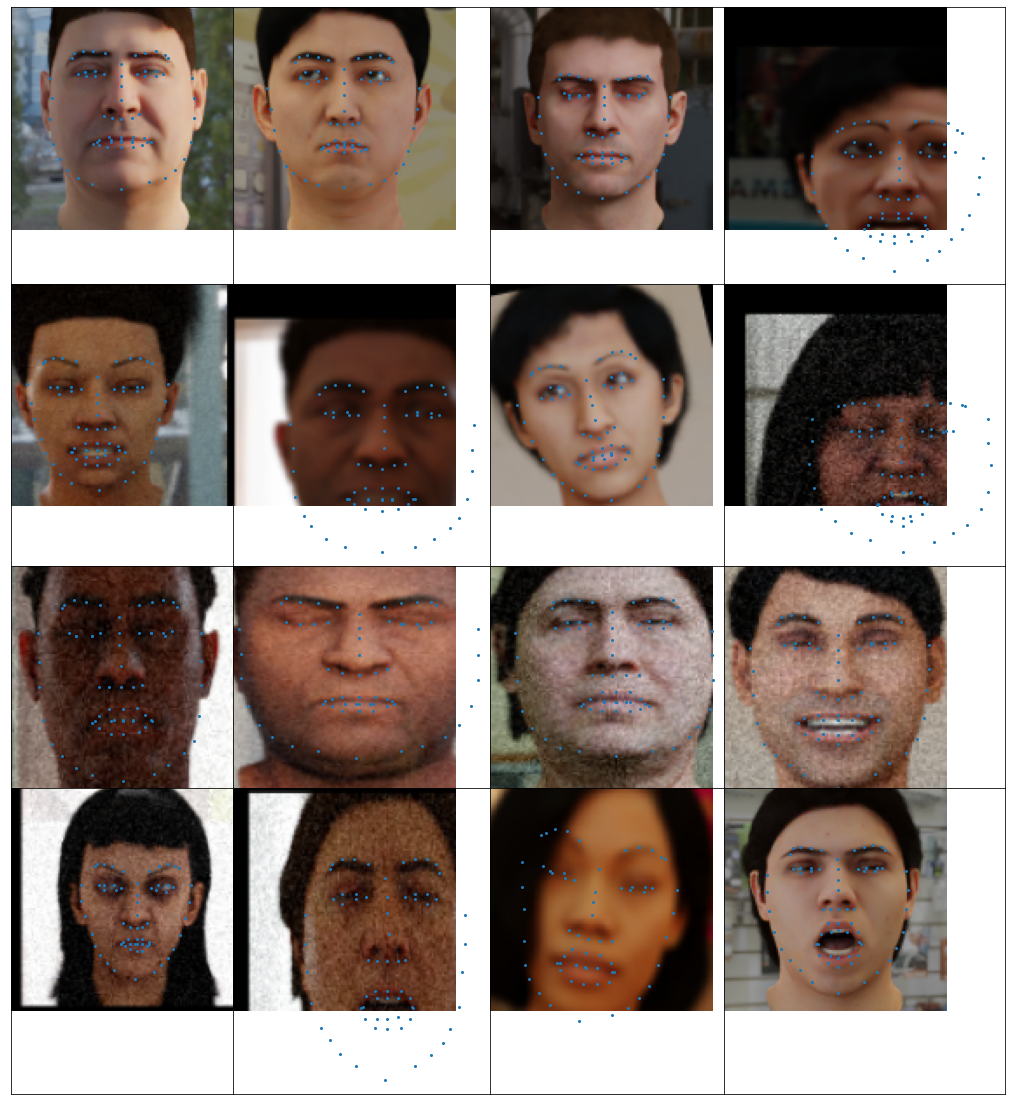

In [7]:
def plot_keypoints(ax, dp):
    img_augmented, keypoints_augmented = augment(dp.visible_spectrum, dp.keypoints.face.standard.coords_2d)
    ax.imshow(img_augmented)
    ax.scatter(*np.flip(keypoints_augmented).T, s=4)
    

plot_grid(fig_shape=(4, 4), input_list=ds, plot_func=plot_keypoints)

### Datasets and DataLoaders definitions

We define a function to access the image and its label from a single datapoint, and perform all the pre-processing.<br>

In [8]:
def Xy_accessor(dp, with_augmentations=False):
    img = dp.visible_spectrum
    keypoints = dp.keypoints.face.standard.coords_2d
    if with_augmentations:
        img, keypoints = augment(img, keypoints)
    img = ToTensor()(img)
    keypoints = torch.tensor(keypoints.flatten().astype('float32'))
    return img, keypoints

We split the dataset into training and test sets and create two PyTorch data loaders. <br>
Augmentations are applied only to training data.

In [9]:
training_data = DGDataset(ds[:SYNTH_TRAINING_SAMPLES], Xy_accessor, with_augmentations=True)
test_data = DGDataset(ds[SYNTH_TRAINING_SAMPLES:], Xy_accessor, with_augmentations=False)

train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE)

## Training on Synthetic Data
### Training setup
We use <b>Adam optimizer with MSE loss</b> and exponential learning rate decay

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = NeuralNetwork().to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = ExponentialLR(optimizer, gamma=0.97)

If a weight file already exists, lets load it. Otherwise, a new one will be created during training.

In [18]:
if os.path.exists(MODEL_PATH):
    checkpoint = torch.load(MODEL_PATH)
    model.load_state_dict(checkpoint)

### Training and test functions

The keypoints array is being flattened and normalized to image size so that the networks predicts values in the [0..1] range. This makes the training process more stable.

In [12]:
def train(dataloader, model, loss_fn, optimizer, scheduler):
    model.train()
    epoch_losses = []
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device) / IMG_SIZE

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss, current = loss.item(), batch * len(X)
        epoch_losses += [loss]
    scheduler.step()
    return np.mean(epoch_losses)


def test(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device) / IMG_SIZE
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches
    return test_loss

### Training loop
<b>IMPORTANT:</b> Since our test set does not include any augmentation, it makes sense that the test loss is lower than the training loss

In [13]:
def train_iteration(train_dataloader, test_dataloader, model, loss_fn, optimizer, scheduler, 
                    model_path, train_losses, test_losses):
    display.display(plt.gcf())
    train_loss = train(train_dataloader, model, loss_fn, optimizer, scheduler)
    train_losses += [train_loss]
    test_loss = test(test_dataloader, model, loss_fn)
    test_losses += [test_loss]
    torch.save(model.state_dict(), model_path)
    plt.clf()
    plt.xlabel('Epoch')
    plt.yscale('log')
    plt.title('MSE Loss')
    plt.plot(train_losses, label='Training loss')
    plt.plot(test_losses, label='Test loss')
    plt.legend()
    display.clear_output(wait=True)

Training complete!


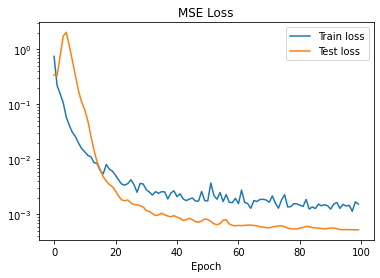

In [13]:
train_losses = []
test_losses = []
for _ in range(TRAINING_EPOCHS):
    train_iteration(train_dataloader, test_dataloader, model, loss_fn, optimizer, scheduler, 
                    MODEL_PATH, train_losses, test_losses)

print("Training complete!")

### Evaluation of the model on the test set
Since the network was overfitted on a very small amount of data, the results on test data are not optimal. <br> Nonetheless, the augmentations made the network much more robust and we can still see nice results on test data.

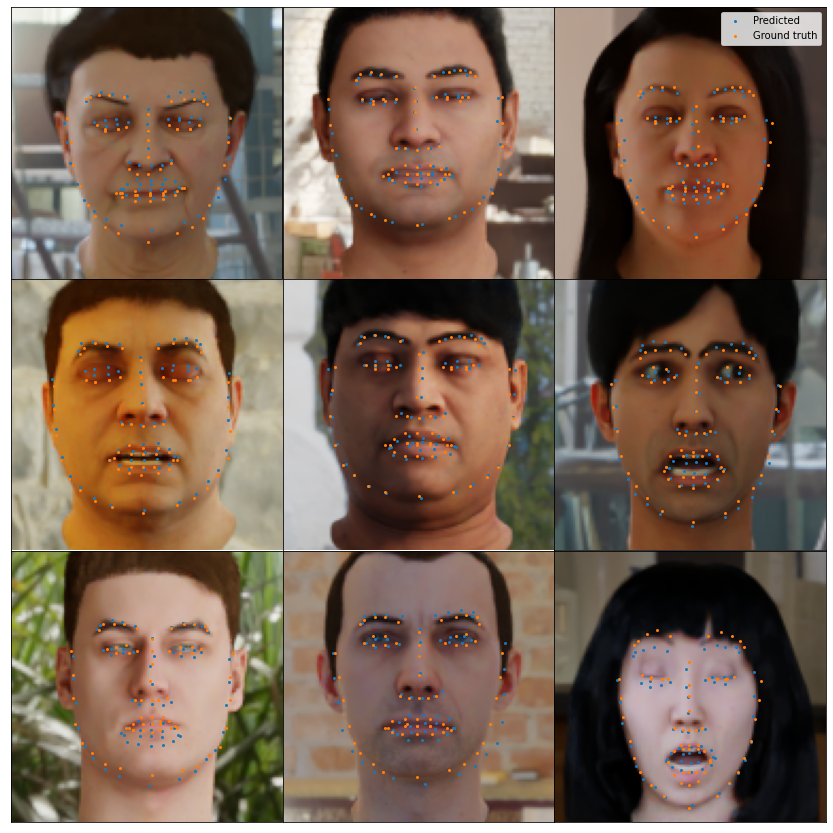

In [17]:
def plot_keypoints(ax, input_dict):
    keypoints_gt = input_dict['keypoints_gt']
    keypoints_pred = input_dict['keypoints_pred']
    ax.imshow(input_dict['img'])
    ax.scatter(*np.flip(keypoints_pred).T, s=4, label='Predicted')
    ax.scatter(*np.flip(keypoints_gt).T, s=4, label='Ground truth')

model.eval()
X, y = next(iter(test_dataloader))
X = X.to(device)
y_pred = model(X).detach().numpy()
X = X.detach().numpy()
y = y.detach().numpy()


input_list = [{'img' : np.moveaxis(X[i], 0, -1), 
               'keypoints_pred': y_pred[i].reshape(NUMBER_OF_KEYPOINTS, 2) * IMG_SIZE, 
               'keypoints_gt': y[i].reshape(NUMBER_OF_KEYPOINTS, 2)} 
              for i in range(len(X))]

plot_grid(fig_shape=(3, 3), input_list=input_list, plot_func=plot_keypoints)
plt.gcf().axes[2].legend()


## Fine-tuning on real data
In order to mitigate the domain gap between synthetic and real data, we will add a small amount of real images into the training pipeline, reduce the learning rate, and train for some additional epochs

### Real data parsing
The first step is to create a new dataset based on the real data we already have. The real data has been taken from [Kaggle 68 facial keypoints dataset](https://www.kaggle.com/datasets/julianlenkiewicz/facialkeypoints68dataset?resource=download) and pre-processed to have the same dimensions as the synthetic data, and to include frontal facing faces only. <br>
Let's load it and show some samples:

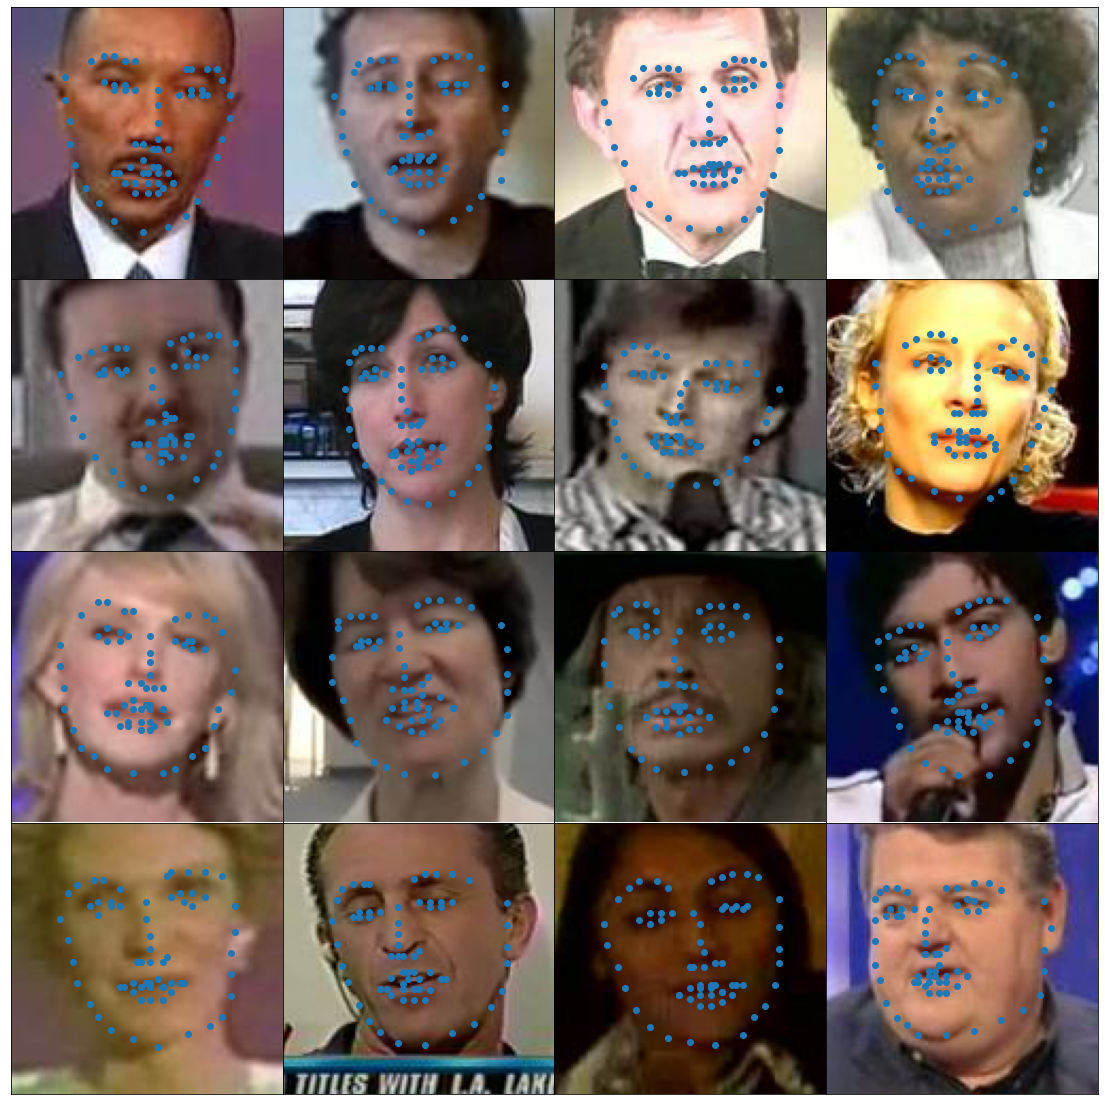

In [15]:
real_dataset_path = join(DATASETS_PATH, 'Real')
img_dir = join(real_dataset_path, 'Images')
keypoints_dir = join(real_dataset_path, 'keypoints.csv')


class ImageWithKeypoints:
    def __init__(self, img, keypoints):
        self.img = img
        self.keypoints = keypoints

        
df = pd.read_csv(keypoints_dir, header=None, index_col=[0])
dp_list = []

for img_file in os.listdir(img_dir):
    if not img_file.endswith(('.jpg', '.png')):
        continue
    img = plt.imread(join(img_dir, img_file))
    keypoints = df.loc[img_file].to_numpy().reshape(NUMBER_OF_KEYPOINTS, 2)
    keypoints = np.flip(keypoints)
    dp_list += [ImageWithKeypoints(img, keypoints)]

def plot_keypoints(ax, dp):
    ax.imshow(dp.img)
    ax.scatter(*np.flip(dp.keypoints).T)

plot_grid(fig_shape=(4, 4), input_list=dp_list, plot_func=plot_keypoints)

### Datasets and DataLoader definitions
Let's now combine some of the real data with the synthetic training data. <br>
We will create a fine-tuning DataLoader for that purpose. The DataLoader will take a small amount of real data and combine it with synthetic data.<br> 
Since the number of real samples is lower than the number of synthetic samples, we will give a <b>higher weight</b> to the real dataset so that both are represented equally in each epoch. <br>
In addition, we will create a real data test set to assess the quality of our model on real data.

In [16]:
def Xy_accessor_real(dp, with_augmentations=False):
    img = dp.img
    keypoints = dp.keypoints
    if with_augmentations:
        img, keypoints = augment(img, keypoints)
    img = ToTensor()(img)
    keypoints = torch.tensor((keypoints.flatten()).astype('float32'))
    return img, keypoints


real_training_dataset_weight = round(SYNTH_TRAINING_SAMPLES / (SYNTH_REAL_RATIO * REAL_TRAINING_SAMPLES))
real_training_data = DGDataset(real_training_dataset_weight * dp_list[:REAL_TRAINING_SAMPLES], Xy_accessor_real, 
                               with_augmentations=True)
real_test_data = DGDataset(dp_list[REAL_TRAINING_SAMPLES:], Xy_accessor_real, with_augmentations=False)
synth_training_data = training_data

print(f'Synthetic training dataset size = {SYNTH_TRAINING_SAMPLES}\n'
f'Real training dataset number of samples = {REAL_TRAINING_SAMPLES}\n'
f'Real training dataset weight = {real_training_dataset_weight}\n'
f'Real training dataset size = {real_training_dataset_weight * REAL_TRAINING_SAMPLES}\n'
f'Real test dataset size = {len(real_test_data)}')


fine_tuning_dataloader = DataLoader(ConcatDataset([real_training_data, synth_training_data]), batch_size=BATCH_SIZE,
                                 shuffle=True)
real_test_dataloader = DataLoader(real_test_data, batch_size=BATCH_SIZE)

Synthetic training dataset size = 90
Real training dataset number of samples = 50
Real training dataset weight = 2
Real training dataset size = 100
Real test dataset size = 16


### Fine-tuning Dataset Visualization
Let's have a look at some fine-tuning samples:

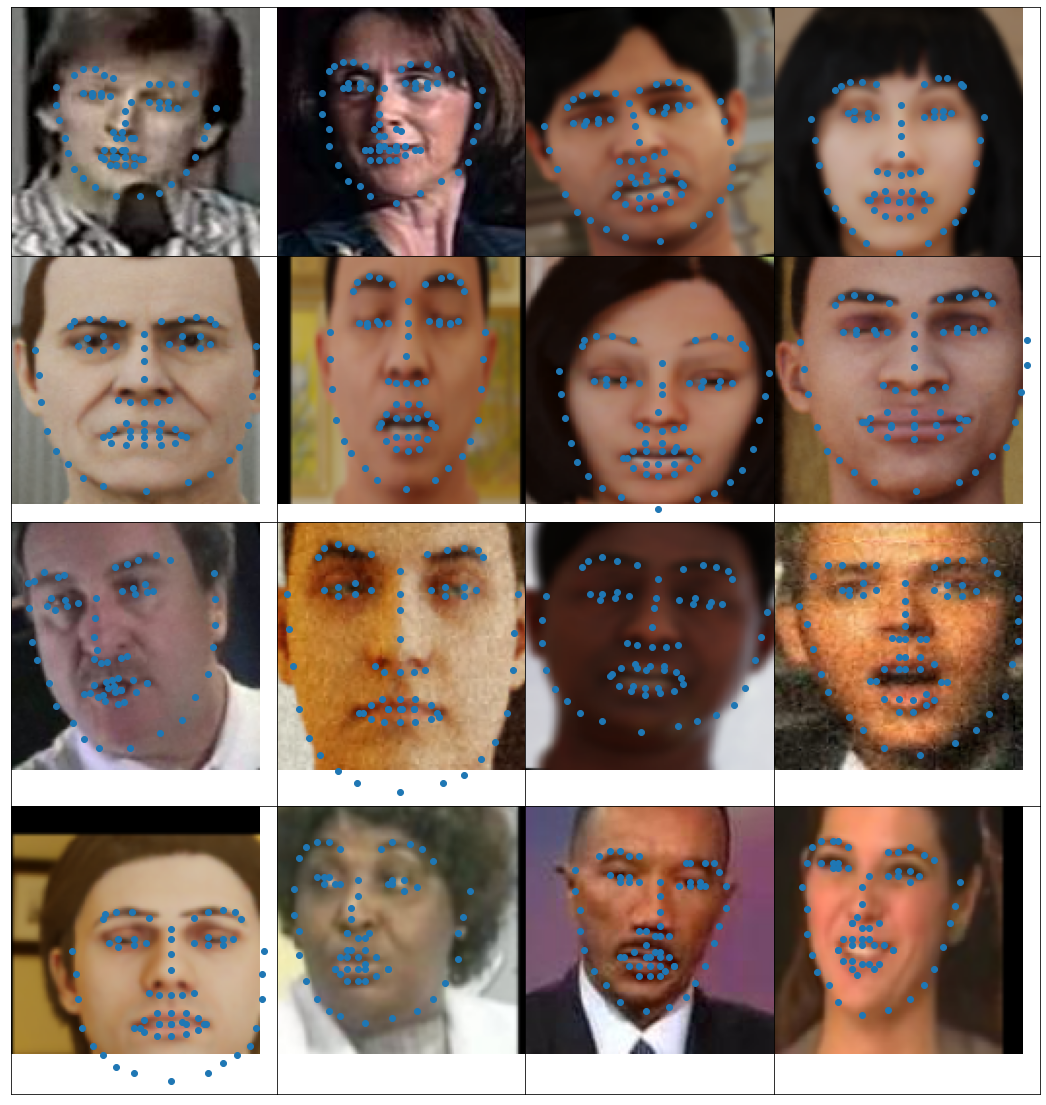

In [74]:
def plot_keypoints(ax, dp):
    ax.imshow(dp['img'])
    ax.scatter(*np.flip(dp['keypoints']).T)

X, y = next(iter(fine_tuning_dataloader))
input_list = [{'img': np.moveaxis(X[i].detach().numpy(), 0, -1),  
               'keypoints': y[i].detach().numpy().reshape(NUMBER_OF_KEYPOINTS, 2)} 
              for i in range(len(X))]
plot_grid(fig_shape=(4, 4), input_list=input_list, plot_func=plot_keypoints)

### Model Training
Let's train the model for some more epoch with a reduced learning rate. <br>
This time, the test loss is on <b>real data only</b>.

Fine-tuning complete!


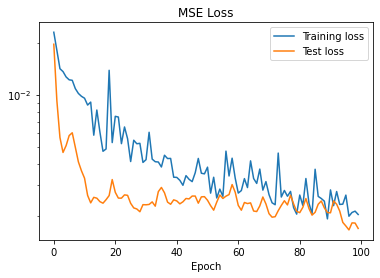

In [19]:
train_losses = []
test_losses = []

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
for _ in range(FINE_TUNING_EPOCHS):
    train_iteration(fine_tuning_dataloader, real_test_dataloader, model, loss_fn, optimizer, scheduler, 
                    MODEL_PATH, train_losses, test_losses)

print("Fine-tuning complete!")

### Evaluation of the model on Real Data
Let's evaluate our model on real data. <br>
Since the model was trained on a very small amount of data, we don't expect it to perform well on real data, but we can still see that the model learned to approximate the keypoints even on many of the <b>real images it didn't see before</b>.

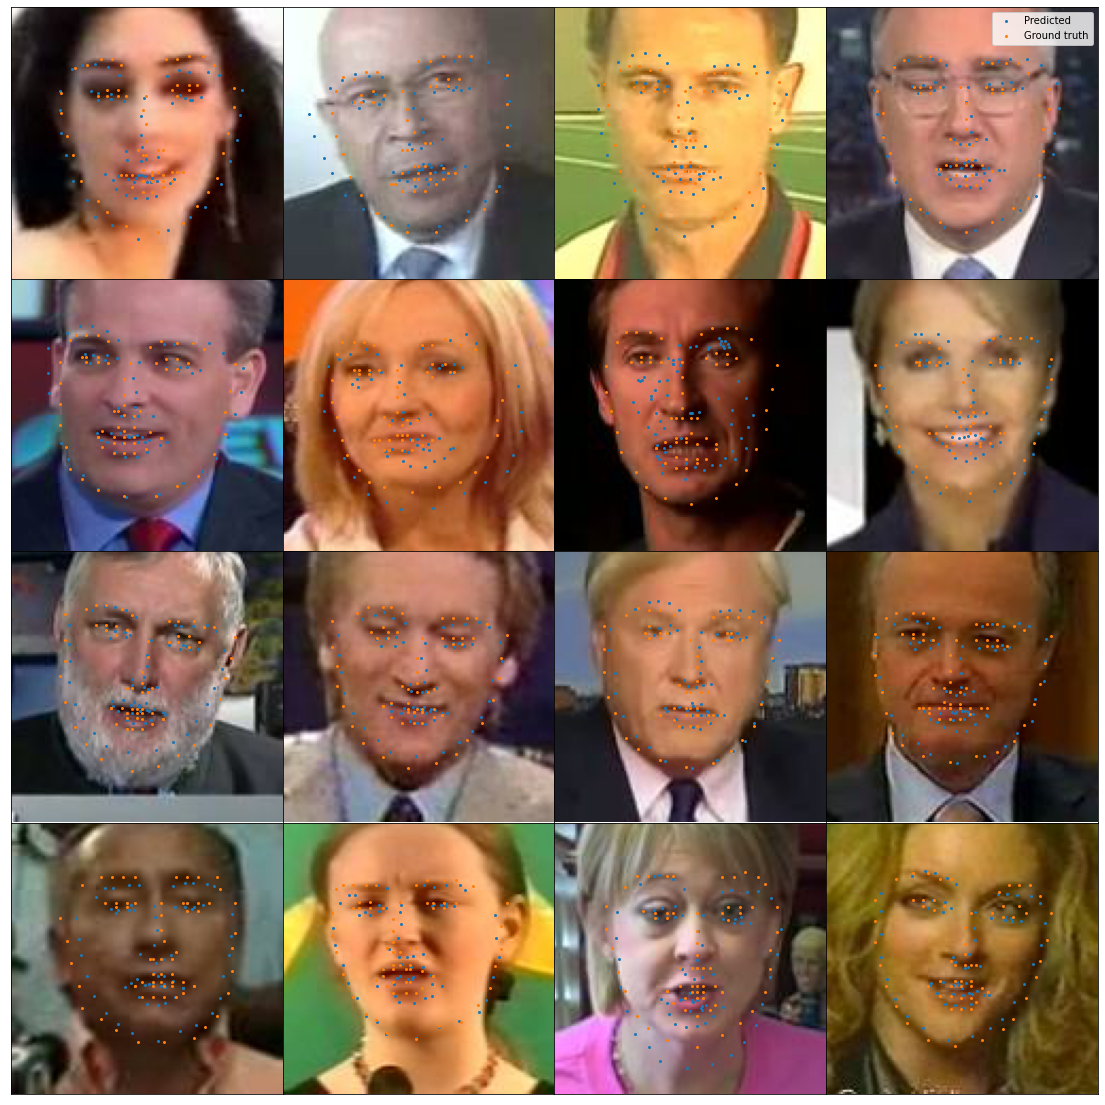

In [17]:
def plot_keypoints(ax, input_dict):
    keypoints_gt = input_dict['keypoints_gt']
    keypoints_pred = input_dict['keypoints_pred']
    ax.imshow(input_dict['img'])
    ax.scatter(*np.flip(keypoints_pred).T, s=4, label='Predicted')
    ax.scatter(*np.flip(keypoints_gt).T, s=4, label='Ground truth')

model.eval()
X, y = next(iter(real_test_dataloader))
X = X.to(device)
y_pred = model(X).detach().numpy()
X = X.detach().numpy()
y = y.detach().numpy()


input_list = [{'img' : np.moveaxis(X[i], 0, -1), 
               'keypoints_pred': y_pred[i].reshape(NUMBER_OF_KEYPOINTS, 2) * IMG_SIZE, 
               'keypoints_gt': y[i].reshape(NUMBER_OF_KEYPOINTS, 2)} 
              for i in range(len(X))]

plot_grid(fig_shape=(4, 4), input_list=input_list, plot_func=plot_keypoints)
plt.gcf().axes[3].legend()